In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import numpy as np

import os
import time

import keras
import keras.layers as layers
from keras import backend as K
from keras.utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


TODO
* Look into saving frames to file

* Clean out cqt stuff 

* Automatic logging of graphs, errors, etc. for comparison
* Add graph of model
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
* Create log output function, then capture to text file (also export graphs?)

* Look for sources of noise that are close to what I want?  Or generate some clips?

* Currently bottom rows are zeroed out - should just remove them
* Debugging tools for comparing, listening to, and viewing clips
* Add audio quality comparisons between clean clips and cleaned clips for evaluation

* Add history error plotting to compare different learning models, topologies, etc.

* Why does https://towardsdatascience.com/audio-ai-isolating-vocals-from-stereo-music-using-convolutional-neural-networks-210532383785 only use real component?
* Evaluate different representations of complex numbers in terms of learnability

* Consider generating custom data for goal - male speakers, low voice, specific sounds

In [2]:
# Constants and settings
WINDOW_SIZE = 25  # Has to be odd
TARGET_COL = WINDOW_SIZE//2

# cqt related
FFT_BINS = 257 # function of items below
HOP_LENGTH = 256

# stft values
N_FFT = 512 # Recommended for speech, music typically 2048

# cqt values
BINS_PER_OCTAVE = 12 * 10
FMIN = librosa.note_to_hz('C1')
OCTAVES = 8

In [3]:
def combine_target(t):
    return (t[0:t.shape[0]//2] + 1j * t[t.shape[0]//2:]).reshape(1,(t.shape[0]//2))

# build up as (bins, samples) then transpose to model view of (samples, bins)
def targets_to_fft(targets):
    fft = np.empty((targets.shape[0],targets.shape[1]//2), dtype='complex64')
    for i in range(0, targets.shape[0]):
        fft[i] = combine_target(targets[i])
    return fft.T   # transpose

# Can't figure out how to raise fmin by an octave, so just throw out bottom octave and fade in over next half
def hpf(ft):
    ft[0:BINS_PER_OCTAVE,:] = 0
    fade = BINS_PER_OCTAVE//2
    for i in range(0,fade):
        ft[BINS_PER_OCTAVE+i,:] = (i/fade) * ft[BINS_PER_OCTAVE+i,:]
    return ft
    
def get_ft(wav):
    #c = librosa.cqt(wav, hop_length=HOP_LENGTH, fmin=FMIN, n_bins=OCTAVES*BINS_PER_OCTAVE, bins_per_octave=BINS_PER_OCTAVE)
    c = librosa.stft(wav, hop_length=HOP_LENGTH, n_fft=N_FFT)
    return c

def inv_ft(ft):
    #return librosa.icqt(ft, hop_length=HOP_LENGTH, bins_per_octave=BINS_PER_OCTAVE)
    return librosa.istft(ft, hop_length=HOP_LENGTH)
    

In [4]:
# Creating data from clip wave file
# Optimization - does frames for each clip in preallocated array
# output is (samples, bins, window size, layers), where image is depth 2 for real & imaginary
def clip_frames(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav) # organized as bins, frames
    bins = fft.shape[0]
    pad = np.zeros((bins,frame_lead))
    frames = np.empty(shape=(fft.shape[1],bins,WINDOW_SIZE,2)) 
    fft = np.concatenate([pad, fft, pad], axis=-1)
    for i in range(0, fft.shape[1] - WINDOW_SIZE + 1):
        frames[i,:,:,0] = fft[:,i:i+WINDOW_SIZE].real
        frames[i,:,:,1] = fft[:,i:i+WINDOW_SIZE].imag
    return frames

# output is array (samples, double bin length made up of real then imag)
def clip_targets(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = get_ft(wav)
    bins = fft.shape[0]
    targets = np.empty(shape=(fft.shape[1],2*FFT_BINS))
    for i in range(0, fft.shape[1]):
        target = fft[:,i:i+1].flatten()
        targets[i,0:bins] = target.real
        targets[i,bins:2*bins] = target.imag
    return targets

In [5]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = get_ft(wav)
print(fft.shape)

(257, 239)


In [6]:
# Iterate over clean & noisy folders to create frames and targets
def create_data(root, max_files = 50):
    clean_dir = root + "\\Clean\\"
    noisy_dir = root + "\\Noisy\\"
    frames = np.empty(shape=(0,FFT_BINS,WINDOW_SIZE,2))
    targets = np.empty(shape=(0,2*FFT_BINS))
    i = 0
    start = time.time()
    check = time.time()
    for file in os.listdir(clean_dir)[0:max_files]:
        i += 1
        if i % 50 == 0:
            print("{0} clips   total {1:.0f}   last cycle {2:.0f}".format(i, time.time() - start,time.time()-check))
            check = time.time()
        filename = os.fsdecode(file)
        frames = np.concatenate((frames,clip_frames(noisy_dir + file)), axis=0)
        targets = np.concatenate((targets,clip_targets(clean_dir + file)), axis=0)
    return frames, targets


In [7]:
frames, targets = create_data("Assets\\DataShareArchive\\Test", 200)

50 clips   total 27   last cycle 27
100 clips   total 66   last cycle 40
150 clips   total 120   last cycle 54
200 clips   total 190   last cycle 70


In [8]:
# Real model (eventually)

inputs = layers.Input(shape=(FFT_BINS,WINDOW_SIZE,2)) # Full window
input_slice = layers.Input(shape=(FFT_BINS,1,2)) # Just the center row that we're trying to predict
conv1 = layers.Conv2D(32, kernel_size=(5,3), activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', 
                      input_shape=[FFT_BINS,WINDOW_SIZE,2])(inputs)
conv2 = layers.Conv2D(32, kernel_size=(5,3), activation=keras.layers.LeakyReLU(alpha=0.3))(conv1) 
pool1 = layers.MaxPooling2D(pool_size=(3,3))(conv2)
conv3 = layers.Conv2D(32, kernel_size=(5,3), activation=keras.layers.LeakyReLU(alpha=0.3))(pool1) 
pool2 = layers.MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = layers.Conv2D(32, kernel_size=1, activation=keras.layers.LeakyReLU(alpha=0.3))(pool2) # Seems like making this too big causes OOM
flat = layers.Flatten()(conv4)
dense0 = layers.Dense(1000, activation=keras.layers.LeakyReLU(alpha=0.3))(flat)
dense1 = layers.Dense(750, activation=keras.layers.LeakyReLU(alpha=0.3))(dense0)
dense2 = layers.Dense(500, activation=keras.layers.LeakyReLU(alpha=0.3))(dense1)
flat_in = layers.Flatten()(input_slice)
merged = layers.concatenate([dense2, flat_in])
outputs = layers.Dense(2*FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs,input_slice], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())






__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 257, 25, 2)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 253, 23, 32)  992         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 249, 21, 32)  15392       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 83, 7, 32)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2

C:\ProgramData\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [13]:
hist = model.fit([frames, frames[:,:,TARGET_COL:TARGET_COL+1,:]], targets, epochs=1, batch_size=32, validation_split=0.05)

Train on 43313 samples, validate on 2280 samples
Epoch 1/1
43313/43313 [==============================] - 57s 1ms/step - loss: 0.0394 - val_loss: 0.0310


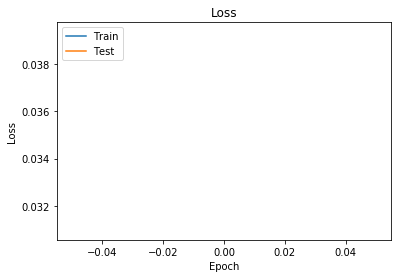

Validation loss mean 5+ epochs nan
Clips  45593


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:

history = hist

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.ylim((0, history.history['loss'][0])) 
plt.show()

#plt.savefig('test.png')
print("Validation loss mean 5+ epochs {0:.4}".format(np.mean(history.history['val_loss'][5:])))
print("Clips ", frames.shape[0])

#Add verification means for 1-10, 11-20, 21-30?  Or slope for different ranges?

Error total  -75.24352188732512  over  122846  =  -0.0006125028237575918


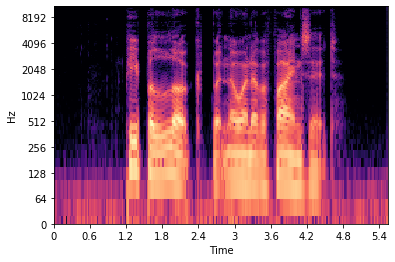

In [16]:
# Full round trip test

verify_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
verify_frames = clip_frames(verify_file)
verify_targets = clip_targets(verify_file)

output_targets = model.predict([verify_frames, verify_frames[:,:,TARGET_COL:TARGET_COL+1,:]])

err = verify_targets - output_targets
print("Error total ", np.sum(err), " over ", err.shape[0] * err.shape[1], " = ", np.sum(err)/(err.shape[0] * err.shape[1]))


p_fft = targets_to_fft(output_targets)
#p_fft = targets_to_fft(verify_targets)

def display_fft(ft):
    #librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='cqt_note', x_axis='time', hop_length=HOP_LENGTH, fmin=FMIN,  bins_per_octave=BINS_PER_OCTAVE)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

display_fft(p_fft)
p_wav = inv_ft(p_fft)
Audio(p_wav,rate=22050)


In [ ]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

print(ft.shape)
print(tt.shape)

#Frame / target check  -  can't use first row because it might be zeroed out
r = 100
print(tt[0,r], tt[0,FFT_BINS+r])
print(ft[0,r,TARGET_COL:TARGET_COL+1,0], ft[0,r,TARGET_COL:TARGET_COL+1,1])

# Round trip test
new_fft = targets_to_fft(tt)
print(new_fft.shape)
new_wav = inv_ft(new_fft)
Audio(new_wav,rate=22050)

In [ ]:
#%%capture cap
print(model.summary())
#with open('output.txt', 'w') as f:
#    f.write(cap.stdout)


In [ ]:
fresh_wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\Noisy\\p232_019.wav")
Audio(fresh_wav, rate=rate)

Test & reference stuff 

In [ ]:
    
def show_fft(wav):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max), y_axis='log', x_axis='time')

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

print(new_fft.shape)

#show_fft(wav)
#show_fft(new_wav)
#Audio(wav, rate=22050)


In [ ]:
# Test stuff for hacking around    
    
a = np.array([[1+2j, 3+4j, 1.5+2.5j],[5+6j,7+8j, 5.5+6.5j]])
print(a)
a1 = a[0]
print(a1)
ar = a1.real
ai = a1.imag

st = np.zeros((6))
st[0:3] = ar
st[3:6] = ai
print(ar.shape, ai.shape, st.shape)
print(ar, ai)
print(st)


In [ ]:
# ''do nothing' model that should be able to guess outputs from outputs

inputs = layers.Input(shape=(FFT_BINS*2,))
dense1 = layers.Dense(2000, activation='relu')(inputs)
dense2 = layers.Dense(2000, activation='relu')(dense1)
#flat = layers.Flatten()(dense)
#flat_in = layers.Flatten()(inputs)
#merged = layers.concatenate([flat, flat_in])
merged = layers.concatenate([dense2, inputs])
linear = layers.Dense(2000, activation='linear')(merged)
outputs = layers.Dense(2*FFT_BINS, activation='linear')(linear)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

model.fit(targets, targets, epochs=1, batch_size=32)